<a href="https://colab.research.google.com/github/max1nehour/Python_projects/blob/main/23_LSTM_daily_30d_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import matplotlib.dates as mdates
import pandas as pd
from glob import glob
import keras as keras
import tensorflow as tf

#列出檔名開頭pm25的檔案
# 2022-2023 共18筆（0.2%)作為test 2017-2020:train 2021:val
dataset_train = glob('drive/MyDrive/pm25/dt*.csv')
df_train = pd.concat(
    (pd.read_csv(file, na_values='NaN',usecols=['pm10','pm25','ws','rh','no2','o3','date','area'], dtype={ 'date': str, 'area':str}) for file in dataset_train ), ignore_index=True)

#replace 'x' by 'nan'
df_train['pm10'] = df_train['pm10'].replace('x','NaN').astype(float)
df_train['pm25'] = df_train['pm25'].replace('x','NaN').astype(float)
df_train['ws'] = df_train['ws'].replace('x','NaN').astype(float)
df_train['rh'] = df_train['rh'].replace('x','NaN').astype(float)
df_train['no2'] = df_train['no2'].replace('x','NaN').astype(float)
df_train['o3'] = df_train['o3'].replace('x','NaN').astype(float)
#nan filliing by mean
#df_train.dropna(subset=['pm25'])
mean = df_train['pm25'].mean()
df_train['pm25'].fillna(mean, inplace=True)
print(df_train)
print(df_train.isnull().sum())

#直接刪除遺失值 但有x的欄位還是被視為str
print(df_train.info())

            date area   pm25    ws     rh    no2     o3   pm10
0         1/1/17   板橋   5.25  2.05  62.25  14.75  27.63  23.50
1         1/2/17   板橋  17.79  1.31  70.10  20.00  23.53  45.58
2         1/3/17   板橋   9.96  2.53  81.00  24.53  21.40  32.58
3         1/4/17   板橋   6.35  2.46  70.38  19.06  21.69  23.87
4         1/5/17   板橋  43.29  1.02  74.46  33.29  15.58  87.17
...          ...  ...    ...   ...    ...    ...    ...    ...
10895  3/15/2021   嘉義  47.00  1.70  66.00  13.60  33.40  73.00
10896  3/15/2021   花蓮  13.00  2.20  66.00   2.10  35.10  25.00
10897  3/15/2021   板橋  31.00  1.70  62.00  32.30  30.20  47.00
10898  3/15/2021   斗六  47.00  1.50  68.00    NaN  40.30  73.00
10899  3/16/2021   小港  36.00  1.90  61.00  26.60  39.40  57.00

[10900 rows x 8 columns]
date     0
area     0
pm25     0
ws      17
rh      18
no2     65
o3      29
pm10    83
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 8 columns):
 #   Colu

## 各變數相關性：資料視覺化

<Axes: >

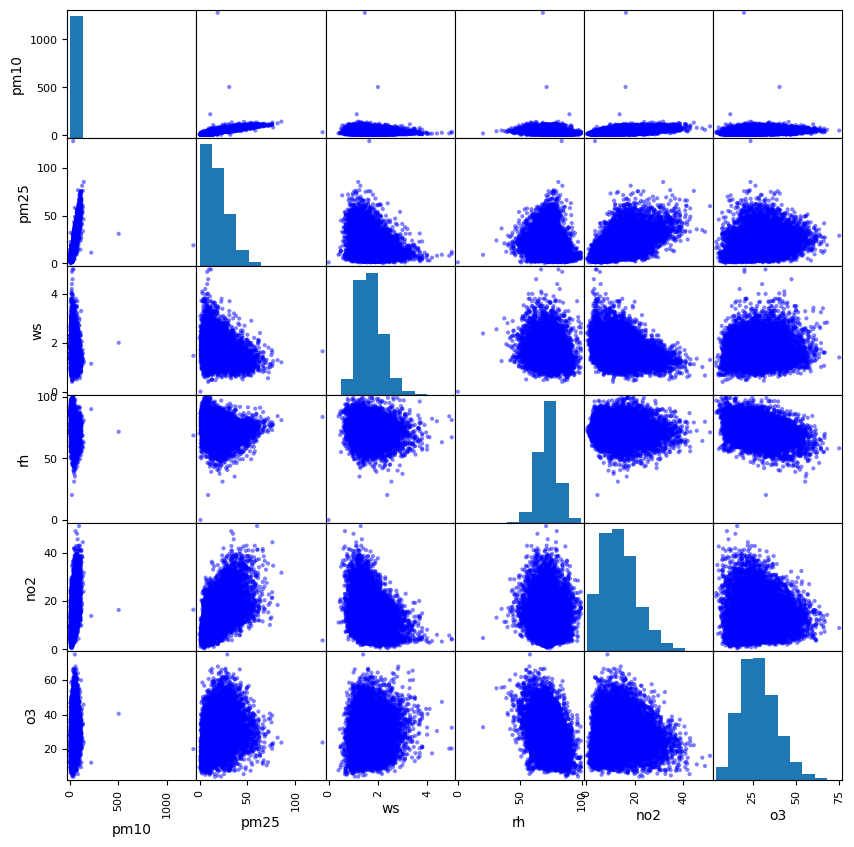

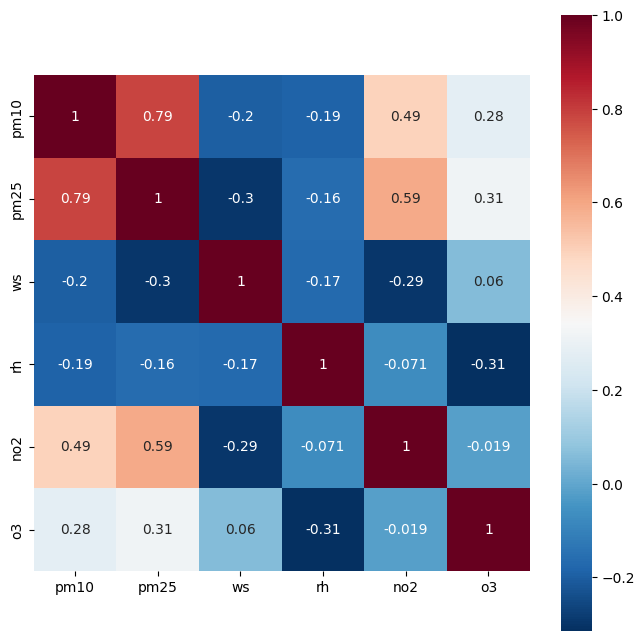

In [2]:

# visualization of train data
from pandas.plotting import scatter_matrix
scatter_matrix( df_train[['pm10','pm25','ws','rh','no2','o3']],figsize=(10, 10),color='b')

import seaborn as sns
# correlation calculate
corr = df_train[['pm10','pm25','ws','rh','no2','o3']].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, square=True, annot=True, cmap="RdBu_r") #center=0, cmap="YlGnBu"

## 測試集資料處理

In [3]:
#data test
df_test = pd.read_csv('drive/MyDrive/pm25/test2022_2023.csv', na_values='NaN')
print(df_test.info())
#replace 'x' by 'nan'
df_test['pm10'] = df_test['pm10'].replace('x','NaN').astype(float)
df_test['pm25'] = df_test['pm25'].replace('x','NaN').astype(float)
df_test['ws'] = df_test['ws'].replace('x','NaN').astype(float)
df_test['rh'] = df_test['rh'].replace('x','NaN').astype(float)
df_test['no2'] = df_test['no2'].replace('x','NaN').astype(float)
df_test['o3'] = df_test['o3'].replace('x','NaN').astype(float)

#datatype transform
#df_test.dropna(subset=['pm25'])
mean = df_test['pm25']
df_test['pm25'].fillna(mean, inplace=True)
print(df_test)
print(df_test.isnull().sum())
#直接刪除遺失值 但有x的欄位還是被視為str
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3241 entries, 0 to 3240
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   no      3241 non-null   int64 
 1   area    3241 non-null   object
 2   date    3241 non-null   object
 3   pm25    3241 non-null   object
 4   ws      3241 non-null   object
 5   rh      3241 non-null   object
 6   no2     3241 non-null   object
 7   o3      3241 non-null   object
 8   pm10    3241 non-null   object
dtypes: int64(1), object(8)
memory usage: 228.0+ KB
None
          no area       date  pm25   ws    rh   no2    o3  pm10
0     352019   板橋  3/22/2022  10.0  1.2  86.0  20.6  24.1  18.0
1     352181   斗六  3/22/2022  34.0  1.6  76.0  13.5  20.8  54.0
2     352115   嘉義  3/22/2022  34.0  2.0  82.0  14.3  22.8  53.0
3     352433   小港  3/22/2022  23.0  2.2  79.0  18.3  14.2  40.0
4     352509   花蓮  3/22/2022  10.0  1.9  95.0   8.1  25.3  19.0
...      ...  ...        ...   ...  ...   ...   ...   ...

In [4]:
# Import the training set 2019以前
site = '板橋'
filt = (df_train['area'] == site)
training_set = df_train.loc[filt, ['pm25']].values
print(training_set)
training_set.shape

[[ 5.25]
 [17.79]
 [ 9.96]
 ...
 [13.  ]
 [18.  ]
 [31.  ]]


(1816, 1)

做 Normalization，將資料壓縮在 [0,1] 之間

In [5]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1)) #控制最大值最小值範圍
training_set_scaled = sc.fit_transform(training_set)#fit_transform: 先對partData作fit()的功能，找到該partData的整體統計特性之指標，如平均值、標準差、最大最小值等等(能依據不同目的套用這些指標在不同的轉換(即後面的transform()動作)上，再實行transform(partData)以對partData進行標準化
print(training_set_scaled.shape)
#training_set_scaled = training_set

(1816, 1)


準備進入訓練的資料格式：設定 Timestep 設為 60 ，代表過去 60 天的資訊，嘗試過數值設置太少，將使 RNN 無法學習。

In [6]:
X_train = []
y_train = []
for i in range(1, 1816):  # 訓練集總數1816
    X_train.append(training_set_scaled[i-1:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
print(X_train, y_train)
print(X_train.shape[1])

[[0.07959369]
 [0.26970891]
 [0.15100061]
 ...
 [0.54578532]
 [0.19708914]
 [0.27289266]] [0.26970891 0.15100061 0.09627047 ... 0.19708914 0.27289266 0.46998181]
1


Reshape
因為現在 X_train 是 2-dimension，將它 reshape 成 3-dimension: [stock prices, timesteps, indicators]

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
print(X_train)

[[[0.07959369]]

 [[0.26970891]]

 [[0.15100061]]

 ...

 [[0.54578532]]

 [[0.19708914]]

 [[0.27289266]]]


#搭建一個 LSTM

In [8]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

搭建 LSTM layer

units: 神經元的數目

第一層的 LSTM Layer 記得要設定input_shape參數

搭配使用dropout，這裡設為 0.2

由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 return_sequences 設為預設值 False （也就是不用寫上 return_sequences）

In [9]:
# Adding the first LSTM layer and some Dropout regularisation
from keras.layers import Flatten, Conv1D, MaxPool1D,MaxPooling1D

#LSTM model
regressor.add(Bidirectional(LSTM(units = 30, return_sequences = True, input_shape = (X_train.shape[1], 1))))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(Bidirectional(LSTM(units = 30, return_sequences = True)))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(Bidirectional(LSTM(units = 30, return_sequences = True)))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(Bidirectional(LSTM(units = 30)))
regressor.add(Dropout(0.2))


In [10]:
# Adding the output layer
regressor.add(Dense(units = 1))

#Compiling & Fitting LSTM model

optimizer: 選擇 Adam

loss: 使用 MSE

In [11]:
# Compiling
import tensorflow as tf
from keras import optimizers
from keras import metrics
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[['mae','accuracy']]) #adam is good at time series data
print(X_train.shape)
#sparse_top_k_
# 進行訓練
history = regressor.fit(X_train, y_train, epochs = 50, batch_size =24)
regressor.summary()
# val_loss 驗證集損失: 比訓練集損失小，是一個好的表現
# Val_accuracy 驗證集準確率
# val_accuracy 衡量模型在未見過的數據上的預測準確性

(1815, 1, 1)
Epoch 1/50
76/76 [==============================] - 28s 13ms/step - loss: 0.0241 - mae: 0.1193 - accuracy: 5.5096e-04
Epoch 2/50
76/76 [==============================] - 1s 12ms/step - loss: 0.0117 - mae: 0.0827 - accuracy: 5.5096e-04
Epoch 3/50
76/76 [==============================] - 1s 13ms/step - loss: 0.0108 - mae: 0.0763 - accuracy: 5.5096e-04
Epoch 4/50
76/76 [==============================] - 1s 13ms/step - loss: 0.0108 - mae: 0.0766 - accuracy: 5.5096e-04
Epoch 5/50
76/76 [==============================] - 1s 13ms/step - loss: 0.0107 - mae: 0.0751 - accuracy: 5.5096e-04
Epoch 6/50
76/76 [==============================] - 1s 12ms/step - loss: 0.0108 - mae: 0.0759 - accuracy: 5.5096e-04
Epoch 7/50
76/76 [==============================] - 1s 12ms/step - loss: 0.0105 - mae: 0.0750 - accuracy: 5.5096e-04
Epoch 8/50
76/76 [==============================] - 1s 12ms/step - loss: 0.0105 - mae: 0.0746 - accuracy: 5.5096e-04
Epoch 9/50
76/76 [==============================] 

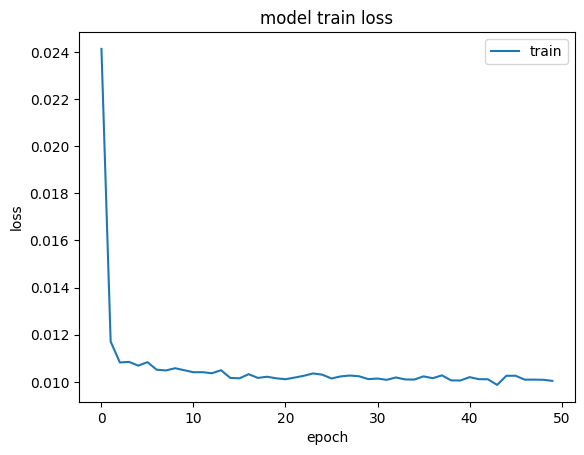

In [12]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train'], loc='upper right')
pyplot.show()

# 進行預測

In [13]:
#取測試 2020的pm2.5
filt2 = (df_test['area'] == site)
real_pm25 = df_test.loc[filt2, ['pm25']].values
print(real_pm25.shape) #540

(540, 1)


In [14]:
#
dataset_total = pd.concat((df_train['pm25'], df_test['pm25']), axis = 0)
print(dataset_total)
inputs = dataset_total[len(dataset_total) - len(df_test) - 1:].values
print(inputs)
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(1,30): # timesteps一樣60； 81 = 20+61
    X_test.append(inputs[i- 1:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

0        5.25
1       17.79
2        9.96
3        6.35
4       43.29
        ...  
3236     4.00
3237    10.00
3238    10.00
3239    15.00
3240    14.00
Name: pm25, Length: 14141, dtype: float64
[36. 10. 34. ... 10. 15. 14.]


In [15]:
#進行預測
predicted_pm25 = regressor.predict(X_test)
predicted_pm25 = sc.inverse_transform(predicted_pm25)  # to get the original scale
print(predicted_pm25)
print(real_pm25)

1/1 [==============================] - 3s 3s/step
[[25.91647  ]
 [11.6083145]
 [25.055029 ]
 [25.055029 ]
 [19.618725 ]
 [11.6083145]
 [ 8.803543 ]
 [ 8.078635 ]
 [14.892947 ]
 [17.923641 ]
 [22.23946  ]
 [ 9.519091 ]
 [10.225145 ]
 [12.285217 ]
 [20.163225 ]
 [22.733328 ]
 [20.697508 ]
 [10.92159  ]
 [ 8.803543 ]
 [18.498951 ]
 [22.23946  ]
 [18.498951 ]
 [21.735573 ]
 [25.490456 ]
 [16.135988 ]
 [12.952208 ]
 [16.135988 ]
 [14.256138 ]
 [14.256139 ]]
[[10.]
 [ 6.]
 [ 8.]
 [21.]
 [17.]
 [ 9.]
 [ 8.]
 [ 4.]
 [21.]
 [ 9.]
 [12.]
 [12.]
 [20.]
 [ 9.]
 [14.]
 [10.]
 [ 0.]
 [ 5.]
 [ 5.]
 [ 7.]
 [ 7.]
 [ 9.]
 [13.]
 [ 7.]
 [10.]
 [ 8.]
 [ 8.]
 [ 7.]
 [ 8.]
 [11.]
 [10.]
 [11.]
 [ 9.]
 [25.]
 [10.]
 [29.]
 [18.]
 [15.]
 [13.]
 [ 4.]
 [ 7.]
 [ 7.]
 [10.]
 [ 8.]
 [ 5.]
 [11.]
 [ 7.]
 [10.]
 [11.]
 [16.]
 [ 4.]
 [ 2.]
 [ 4.]
 [ 9.]
 [ 7.]
 [ 5.]
 [ 4.]
 [ 5.]
 [ 9.]
 [ 9.]
 [ 8.]
 [ 6.]
 [11.]
 [11.]
 [10.]
 [15.]
 [13.]
 [11.]
 [13.]
 [12.]
 [ 4.]
 [ 5.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 6

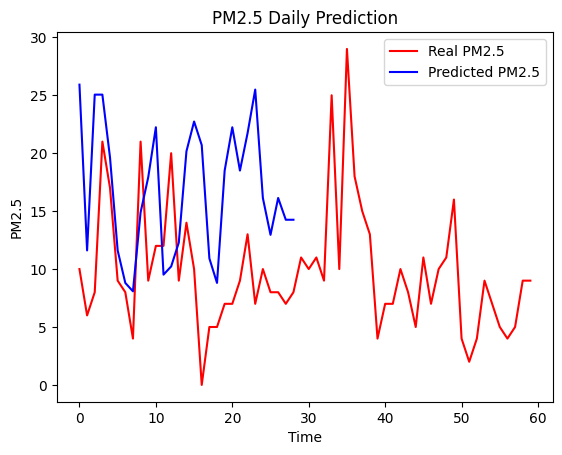

In [21]:
#x = df_test['Date']

plt.plot(real_pm25[0:60], color = 'red', label = 'Real PM2.5')  # 紅線表示真實股價
plt.plot(predicted_pm25, color = 'blue', label = 'Predicted PM2.5')  # 藍線表示預測股價
plt.title('PM2.5 Daily Prediction')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


## **result evaluation (statistic methods)**

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(real_pm25[0:29], predicted_pm25))
mae = mean_absolute_error(real_pm25[0:29], predicted_pm25)
r2 = r2_score(real_pm25[0:29], predicted_pm25)

print("RSQUARE",r2)
print("RMSE:", rmse)
print("MAE:", mae)

RSQUARE -2.984501663190322
RMSE: 9.699665587946553
MAE: 8.243939301063275
